# Import and Sort Data

In [1]:
# import internal files
from historymatch import emulators
from historymatch import sample
from historymatch import historymatch
from historymatch import plot
from historymatch import utils


# import external modules
import numpy as np
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy import stats, spatial
import os
from matplotlib import rc
import matplotlib
import pandas as pd
#import statsmodels.api as sm
import importlib
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
#sns.set('talk')
#import corner
import math
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler


import sklearn.linear_model as skl

plt.rcParams.update({'font.size': 10})

rc('font',**{'family':'serif'})
rc('text', usetex=True)
params= {'text.latex.preamble' : [r'\usepackage{bm}']}
plt.rcParams.update(params)

matplotlib.rcParams['axes.linewidth'] = 1.2

In [44]:
SMALL_SIZE = 30
MEDIUM_SIZE = 30
BIGGER_SIZE = 26


plt.rc('font', size=26)          # controls default text sizes
plt.rc('axes', titlesize=28)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=28)    # fontsize of the tick labels
plt.rc('ytick', labelsize=28)    # fontsize of the tick labels
plt.rc('legend', fontsize=22)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

In [3]:
# import data

with open("data/MassEval2016.dat",'r') as infile:
    Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11,12),
              names=('N', 'Z', 'A', 'Element', 'Ebinding', 'E_unc'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=64,
              index_col=False)
    
# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
Masses['E_unc'] = pd.to_numeric(Masses['E_unc'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000
Masses['E_unc'] /= 1000

# Group the DataFrame by nucleon number, A.
Masses_all = Masses.groupby('A')
Masses_all_0 = Masses.sort_values(['Z','Ebinding'],ascending=False)

Masses = Masses.sort_values(['A','Ebinding'],ascending=False).groupby('A').head(3)

A0 = Masses['A'].to_numpy()
Z0 = Masses['Z'].to_numpy()
N0 = Masses['N'].to_numpy()
Element = Masses['Element'].to_numpy()

# convert energies per nucleon to energies
Energies0 = Masses['Ebinding'].to_numpy()

Energies_unc0 = Masses['E_unc'].to_numpy()


# Find the rows of the grouped DataFrame with the maximum binding energy.
Masses_single = Masses.groupby('A').apply(lambda t: t[t.Ebinding==t.Ebinding.max()])

A0_single = Masses_single['A'].to_numpy()
Z0_single = Masses_single['Z'].to_numpy()
N0_single = Masses_single['N'].to_numpy()
Element_single = Masses_single['Element'].to_numpy()

# convert energies per nucleon to energies
Energies0_single = Masses_single['Ebinding'].to_numpy()

Energies_unc0_single = Masses_single['E_unc'].to_numpy()

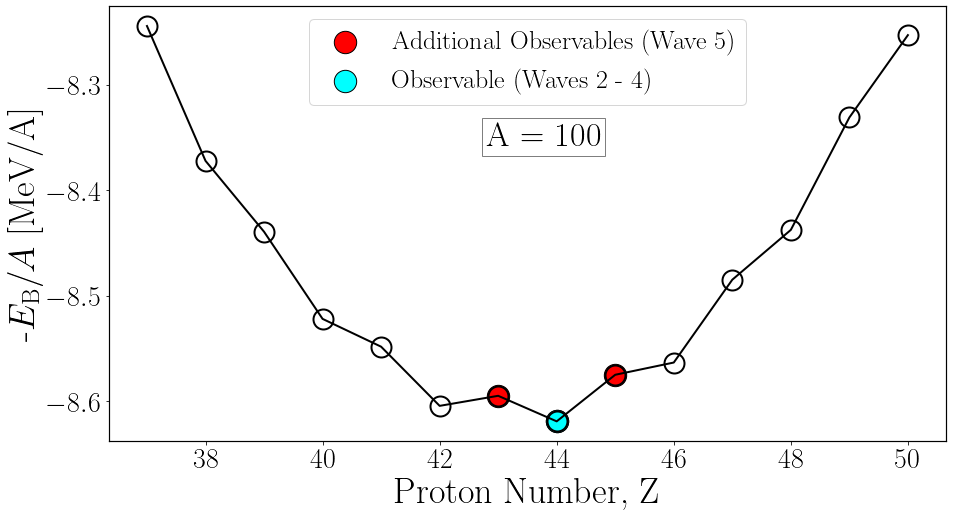

In [4]:
A101 = Masses_all_0['A'][Masses_all_0['A'] == 100]
Z101 = Masses_all_0['Z'][Masses_all_0['A'] == 100]
E101 = Masses_all_0['Ebinding'][Masses_all_0['A'] == 100]

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(Z101, -E101, lw=2, marker='o', mfc='None', mew=2, ms=20, color='black')
ax.scatter(Z101[5:8], -E101[5:8], lw=1, marker='o', s=500, ec='black', color='red', label = 'Additional Observables (Wave 5)' )
ax.scatter(Z101[6:7], -E101[6:7], lw=1, marker='o', s=500, ec='black', color='cyan', label = 'Observable (Waves 2 - 4)')

ax.set_xlabel('Proton Number, Z')
ax.set_ylabel(r'-$E_{\mathrm{B}}/A$ [MeV/A]')

ax.text(0.45, 0.70, 'A = 100', transform=ax.transAxes, fontsize=34,
        verticalalignment='center', bbox = dict(facecolor = 'white', alpha = 0.5))
ax.legend(loc='best')
plt.savefig('figures/Z_E_A101.pdf', bbox_inches='tight', facecolor='white', transparent=False)

In [5]:
# select spaced energies over interval

start = 30
step = 1
stop = -1

start1 = 10
step1 = 1
stop1 = -1

# wave 0 - 3
Energies_single = (Energies0_single)[start1:stop1:step1]
Energies_unc_single = (Energies_unc0_single)[start1:stop1:step1]
A_single = (A0_single)[start1:stop1:step1]
Z_single = (Z0_single)[start1:stop1:step1]
N_single = (N0_single)[start1:stop1:step1]

#wave 4 and 5
Energies = np.flip(Energies0)[start:stop:step]
Energies_unc = np.flip(Energies_unc0)[start:stop:step]
A = np.flip(A0)[start:stop:step]
Z = np.flip(Z0)[start:stop:step]
N = np.flip(N0)[start:stop:step]

print(A)

[ 20  20  20  21  21  21  22  22  22  23  23  23  24  24  24  25  25  25
  26  26  26  27  27  27  28  28  28  29  29  29  30  30  30  31  31  31
  32  32  32  33  33  33  34  34  34  35  35  35  36  36  36  37  37  37
  38  38  38  39  39  39  40  40  40  41  41  41  42  42  42  43  43  43
  44  44  44  45  45  45  46  46  46  47  47  47  48  48  48  49  49  49
  50  50  50  51  51  51  52  52  52  53  53  53  54  54  54  55  55  55
  56  56  56  57  57  57  58  58  58  59  59  59  60  60  60  61  61  61
  62  62  62  63  63  63  64  64  64  65  65  65  66  66  66  67  67  67
  68  68  68  69  69  69  70  70  70  71  71  71  72  72  72  73  73  73
  74  74  74  75  75  75  76  76  76  77  77  77  78  78  78  79  79  79
  80  80  80  81  81  81  82  82  82  83  83  83  84  84  84  85  85  85
  86  86  86  87  87  87  88  88  88  89  89  89  90  90  90  91  91  91
  92  92  92  93  93  93  94  94  94  95  95  95  96  96  96  97  97  97
  98  98  98  99  99  99 100 100 100 101 101 101 10

In [6]:
# split nuclei in to groups (for waves)

# A - (20,40), (40,140), (140,200), (200+)
nuclei_groups1 = [[0,21], [21, 120], [120, 180], [180, -1]]
nuclei_groups = [[0,60], [60, 360], [360, 540], [540, -1]]

In [7]:
evenodd = 0
eveneven = 0
oddodd = 0

for i in range(len(A)):
    Atot = Z[i]+N[i]
    if Atot % 2 == 0:
        if Z[i] % 2 == 0:
            eveneven += 1
        else:
            oddodd += 1
    else:
        evenodd += 1
        
        
print(eveneven)
print(oddodd)
print(evenodd)

232
131
363


In [8]:
ndim = 5

In [9]:
# define parameter space

theta_0_bound = np.array([15.5, 16]).reshape(1,-1)
theta_1_bound = np.array([-18.5, -18]).reshape(1,-1)
theta_2_bound = np.array([-0.73, -0.7]).reshape(1,-1)
theta_3_bound = np.array([-24, -23]).reshape(1,-1) # keep
theta_4_bound = np.array([8, 14]).reshape(1,-1)

parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, \
                                   theta_2_bound, theta_3_bound, theta_4_bound), axis=0)


# create parameter arrays for plotting
theta_0_vals = np.linspace(parameter_bounds[0,0], parameter_bounds[0,1], 100)
theta_1_vals = np.linspace(parameter_bounds[1,0], parameter_bounds[1,1], 100)
theta_2_vals = np.linspace(parameter_bounds[2,0], parameter_bounds[2,1], 100)
theta_3_vals = np.linspace(parameter_bounds[3,0], parameter_bounds[3,1], 100)
theta_4_vals = np.linspace(parameter_bounds[4,0], parameter_bounds[4,1], 100)


theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), theta_2_vals.reshape(1,-1), theta_3_vals.reshape(1,-1), theta_4_vals.reshape(1,-1)), axis=0)


In [10]:
def LiquidDropModel(A, Z, N, *parameters):
    
    indep_var = [A, (A**(2.0/3.0)), Z*(Z-1)*(A**(-1.0/3.0)), \
                 ((N-Z)**2)/A, ( (-1)**Z + (-1)**N )/(2*A**(0.5))]
    
    E_B = 0
    
    for i in range(len(parameters)):
        E_B += parameters[i]*indep_var[i]
    
    return E_B / A

In [11]:
def testfunc(x,z):
    return 5.04909761 - 14.95452167*(x**(2.0/3.0))/x - 0.85468996*z*(z-1)*(x**(-1.0/3.0))/x

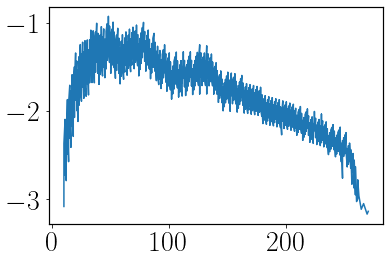

In [12]:
A_single
zarray = np.linspace(1,100,247)

plt.plot(A0, testfunc(A0,Z0))

# Linear Regression

In [13]:
indep_var = [1, (A**(2.0/3.0))/A, \
             Z*(Z-1)*(A**(-1.0/3.0))/A, \
                 ((N-Z)**2)/(A**2), \
             ( (-1)**Z + (-1)**N )/(A*(2*A**(0.5)))]



indep_var_single = [1, (A_single**(2.0/3.0))/A_single, \
             Z_single*(Z_single-1)*(A_single**(-1.0/3.0))/A_single, \
                 ((N_single-Z_single)**2)/(A_single**2), \
             ( (-1)**Z_single + (-1)**N_single )/(A_single*(2*A_single**(0.5)))]


def design_matrix(ndim):
    # design matrix X
    X = np.zeros((len(A),ndim))
    for i in range(ndim):
        X[:,i] = indep_var[i]
    return X

def design_matrix_single(ndim):
    # design matrix X
    X = np.zeros((len(A_single),ndim))
    for i in range(ndim):
        X[:,i] = indep_var_single[i]
    return X

def design_matrix_Agroup(ndim, A, Z, N, maxA, ap=False):
    # design matrix X
    if ap == True:
        X = np.zeros((len(A[:maxA]),ndim))
    else:
        X = np.zeros((len(A[:maxA]),ndim-1))
    X[:,0] = np.ones(len(A[:maxA]))
    X[:,1] = (A[:maxA]**(2.0/3.0))/A[:maxA]
    X[:,2] = Z[:maxA]*(Z[:maxA]-1)*(A[:maxA]**(-1.0/3.0))/A[:maxA]
    X[:,3] = ((N[:maxA]-Z[:maxA])**2)/(A[:maxA]**2)
    if ap == True:
        X[:,4] = ( (-1)**Z[:maxA] + (-1)**N[:maxA] )/(A[:maxA]*(2*A[:maxA]**(0.5)))
    return X


In [14]:
# wave 2 coefficients

clf_4d_single = skl.LinearRegression(fit_intercept=False).fit(design_matrix_single(4), Energies_single)

print(clf_4d_single.coef_)

[ 15.66756039 -17.78825237  -0.70925804 -22.93282687]


In [15]:
# solve for coefficients

clf_2d = skl.LinearRegression(fit_intercept=False).fit(design_matrix_single(2), Energies_single)

clf_3d = skl.LinearRegression(fit_intercept=False).fit(design_matrix_single(3), Energies_single)

clf_4d = skl.LinearRegression(fit_intercept=False).fit(design_matrix(4), Energies)

clf_5d = skl.LinearRegression(fit_intercept=False).fit(design_matrix(5), Energies)

print('2D coefficients : ' + str(clf_2d.coef_))
print('3D coefficients : ' + str(clf_3d.coef_))
print('4D coefficients : ' + str(clf_4d.coef_))
print('5D coefficients : ' + str(clf_5d.coef_))

# permanently define true 5D coefficients
true_coef = [15.80182161, -18.25615687, -0.71711348, -23.25922415, 11.25030928]

# binding energy predictions
preds_5d = clf_5d.predict(design_matrix(5))
preds_4d = clf_4d.predict(design_matrix(4))
preds_3d = clf_3d.predict(design_matrix_single(3))
preds_2d = clf_2d.predict(design_matrix_single(2))


err2d = np.sum(np.square(Energies_single-preds_2d))
err3d = np.sum(np.square(Energies_single-preds_3d))
err4d = np.sum(np.square(Energies-preds_4d))
err5d = np.sum(np.square(Energies-preds_5d))

# final error on each observable in 5D

pred_sigmas = [np.sqrt(err2d / (len(Energies) - 2)), np.sqrt(err3d / (len(Energies) - 3)), np.sqrt(err4d / (len(Energies) - 4)), \
                np.sqrt(err5d / (len(Energies) - 5))]

pred_sigma_5d = np.sqrt(err5d / (len(Energies) - 5))
pred_sigma_4d = np.sqrt(err4d / (len(Energies) - 4))
pred_sigma_3d = np.sqrt(err3d / (len(Energies) - 3))
pred_sigma_2d = np.sqrt(err2d / (len(Energies) - 2))

# from literature:
# < 40: 11 % : 0.997
# < 140: 1.5% : 0.136 
# < 200: 0.8% : 0.072
# > 200: 0.2% : 0.018

print(pred_sigma_5d)

2D coefficients : [6.98239382 5.90470525]
3D coefficients : [ 15.04909761 -14.95452167  -0.85468996]
4D coefficients : [ 15.77120296 -18.14776699  -0.71613235 -23.07216757]
5D coefficients : [ 15.80182161 -18.25615687  -0.71711348 -23.25922415  11.25030928]
0.024194172191448825


In [16]:
# compute residual error for each range of A

# A < 20
#group0_sig = np.sqrt(np.sum(np.square(Energies[:nuclei_groups[0][1]] - \
                                      #LiquidDropModel(A[:nuclei_groups[0][1]], Z[:nuclei_groups[0][1]],\
                                                      #N[:nuclei_groups[0][1]], *true_coef))) / \
                                                     #(len(Energies[:nuclei_groups[0][1]]) - 5))

# 20 < A < 40
group1_sig = np.sqrt(np.sum(np.square(Energies_single[:nuclei_groups[0][1]] - \
                                      LiquidDropModel(A_single[:nuclei_groups[0][1]], Z_single[:nuclei_groups[0][1]], \
                                                      N_single[:nuclei_groups[0][1]], *true_coef))) / \
                                                         (len(Energies_single[:nuclei_groups[0][1]]) - 4))

# 40 < A < 140
group2_sig = np.sqrt(np.sum(np.square(Energies_single[:nuclei_groups[1][1]] - \
                                      LiquidDropModel(A_single[:nuclei_groups[1][1]], Z_single[:nuclei_groups[1][1]], \
                                                      N_single[:nuclei_groups[1][1]], *true_coef))) / \
                                                         (len(Energies_single[:nuclei_groups[1][1]]) - 5))

# 140 < A < 200
group3_sig = np.sqrt(np.sum(np.square(Energies_single[:nuclei_groups[2][1]] - \
                                      LiquidDropModel(A_single[:nuclei_groups[2][1]], Z_single[:nuclei_groups[2][1]], \
                                                      N_single[:nuclei_groups[2][1]], *true_coef))) / \
                                                         (len(Energies_single[:nuclei_groups[2][1]]) - 5))

# A > 200
group4_sig = np.sqrt(np.sum(np.square(Energies_single[:nuclei_groups[3][1]] - \
                                      LiquidDropModel(A_single[:nuclei_groups[3][1]], Z_single[:nuclei_groups[3][1]], \
                                                      N_single[:nuclei_groups[3][1]], *true_coef))) / \
                                                         (len(Energies_single[:nuclei_groups[3][1]]) - 5))

sigma_model_groups = [0.09, 0.05, 0.04, 0.02]
print(group1_sig)
print(group2_sig)
print(group3_sig)
print(group4_sig)
print(A_single[0:nuclei_groups1[1][1]])

0.041025823437722014
0.024986938624559463
0.024986938624559463
0.025038716679213927
[ 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139]


# Coefficient Pertubations

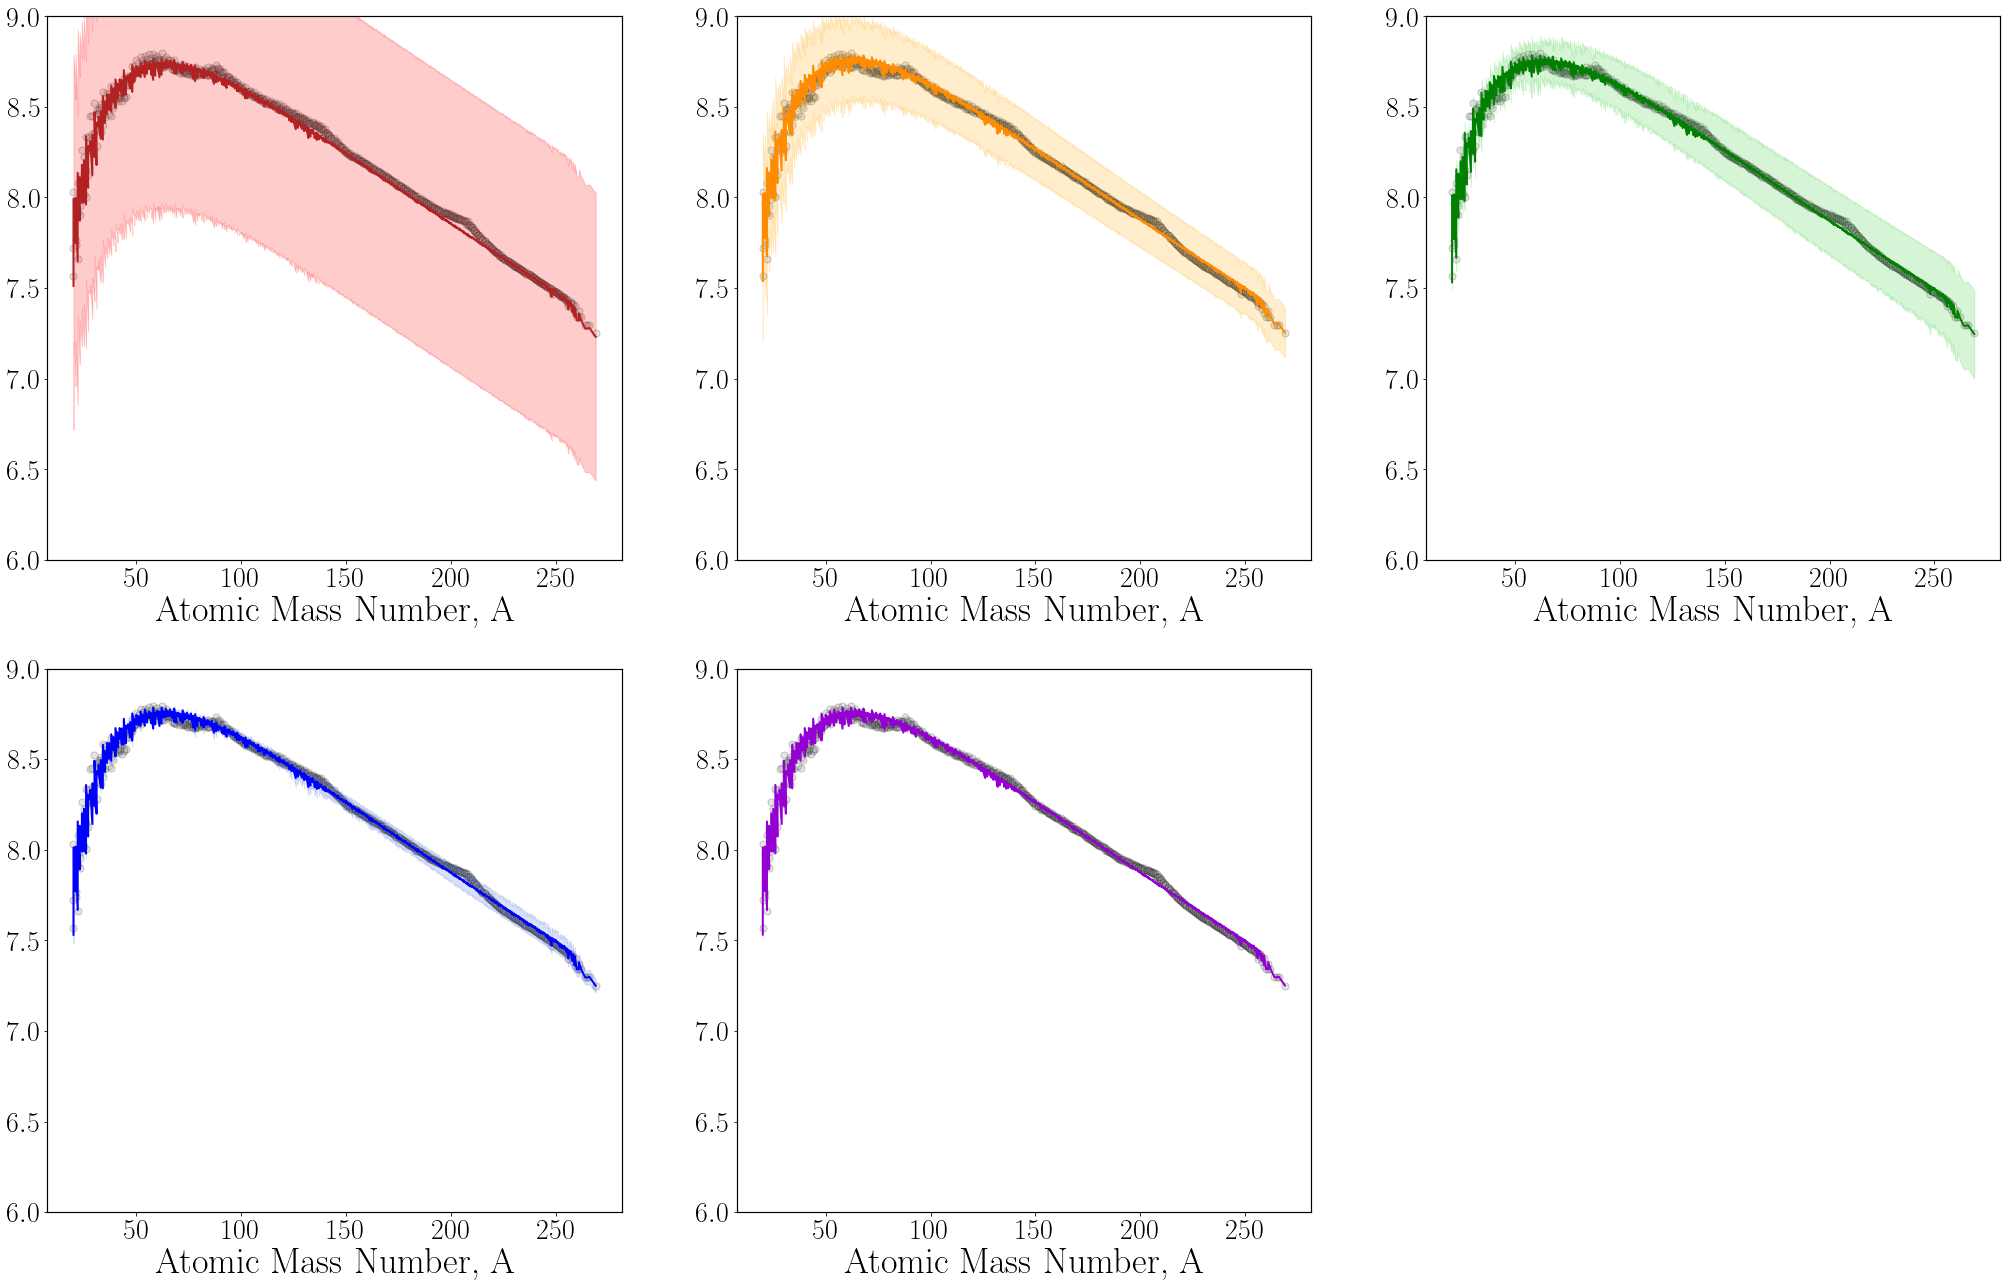

In [17]:
# compute outputs given small pertubation on *each* parameter separately
meanpert_colors = ['firebrick', 'darkorange', 'green', 'blue', 'darkviolet']
pertubation_colors = ['red', 'orange', 'limegreen', 'royalblue', 'darkviolet']
fig, axes = plt.subplots(2,3,figsize=(35,22))
axes[1,2].axis('off')
subscript_list = [r'{\textrm{v}}', r'{\textrm{s}}', r'{\textrm{c}}', r'{\textrm{a}}', r'{\textrm{p}}']


# add small pertubations to coef
Npertubations = 1000

for j in range(ndim):
    
    if j < 3:
        ax = axes[0,j]
    else:
        ax = axes[1,j-ndim-1]
    
    EB_perturbed = np.zeros((Npertubations, len(A)))
    
    # plot datapoints
    true_pts = ax.scatter(A, Energies, ec='black', fc='gray', s=50, zorder=1, alpha=0.2)
    
    for i in range(Npertubations):
        coef_peturbed = [ 15.80182161, -18.25615687,  -0.71711348, -23.25922415,  11.25030928]
        pert_sd = np.abs(coef_peturbed[j]*0.05)
        epsilon = np.random.normal(0,pert_sd)
        coef_peturbed[j] += epsilon
        EB_perturbed[i] = LiquidDropModel(A, Z, N, *coef_peturbed)
        
        # calculate mean and variance of perturbed energies
        
    eb_mean = np.mean(EB_perturbed, axis=0)
    eb_var = np.var(EB_perturbed, axis=0)


    pert_mean, = ax.plot(A, eb_mean,\
        color = meanpert_colors[j], linewidth=2, alpha=1, zorder=3, label=str(j))


    pert_sigma = ax.fill_between(A, (eb_mean+np.sqrt(eb_var)), (eb_mean-np.sqrt(eb_var)),\
        color = pertubation_colors[j], alpha=0.2, zorder=2)
    
    #ax.legend([true_pts, (pert_sigma, pert_mean)], ['AME2016', r'$\overline{{M}}(a_{}+\epsilon) \pm \sigma$'.format(subscript_list[j])], loc='lower left')
    
    ax.set_ylim([6,9])
    ax.set_xlabel('Atomic Mass Number, A')
    #ax.set_ylabel(r'$E_{\textrm{B}}$ / Nucleon [MeV]')

#plt.savefig('figures/parameter_pertubation_2.png', bbox_inches='tight', facecolor='white', transparent=False)

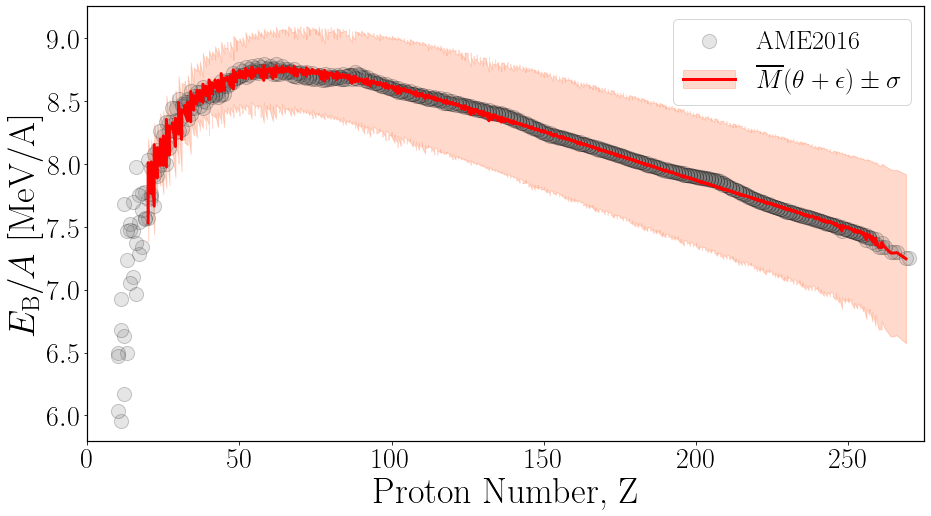

In [18]:
# look at small pertubations on parameters

fig, ax = plt.subplots(figsize=(15,8))
# plot datapoints
true_pts = ax.scatter(A0, Energies0, ec='black', fc='gray', s=200, zorder=2, alpha=0.2)
# plot with true coefs (5d model)
#ax.plot(A0, LiquidDropModel(A0, Z0, N0, *clf_6d.coef_), zorder=3, linewidth=3, color='black', label=r'$M(\theta)$')

# add small pertubations to coef

nperts = 1000
EB_pert = np.zeros((nperts, len(A)))

for i in range(nperts):
    epsilon = np.random.normal(0,0.1,len(clf_5d.coef_))
    #epsilon = np.random.uniform(0,s,len(clf_6d.coef_))
    coef_peturbed = clf_5d.coef_ + epsilon
    EB_pert[i] = LiquidDropModel(A, Z, N, *coef_peturbed)

    # plot with peturbed coefs (5d model)
    #if i == 0:
        #ax.plot(A0, LiquidDropModel(A0, Z0, N0, *coef_peturbed),\
            #color='orangered', alpha=0.6, zorder=1, label=r'$M(\theta+\epsilon)$')
    #else:
        #ax.plot(A0, LiquidDropModel(A0, Z0, N0, *coef_peturbed),\
            #color='orangered', alpha=0.2, zorder=1)

eb_mean = np.mean(EB_pert, axis=0)
eb_var = np.var(EB_pert, axis=0)


pert_mean, = ax.plot(A, eb_mean,\
            color='red', linewidth=3, alpha=1, zorder=3)


pert_sigma = ax.fill_between(A, (eb_mean+np.sqrt(eb_var)), (eb_mean-np.sqrt(eb_var)),\
            color='orangered', alpha=0.2, zorder=1)

#ax.legend(loc='best')

ax.legend([true_pts, (pert_sigma, pert_mean)], ['AME2016', r'$\overline{M}(\theta+\epsilon) \pm \sigma$'], loc='upper right')


#ax.set_ylim([6.2,9.8])
ax.set_xlim([0,275])
ax.set_xlabel('Proton Number, Z')
ax.set_ylabel(r'$E_{\mathrm{B}}/A$ [MeV/A]')
plt.savefig('figures/parameter_pertubation.pdf', bbox_inches='tight', facecolor='white', transparent=False)


# Observable Selection

[200 201 202 204 205 206 208 209 210 212 213 214 216 217 218 220 221 222
 224 225 226 228 229 230 232 233 234 236 237 238 240 241 242 244 245 246
 248 249 250 252 253 254 256 257 259 261 266]


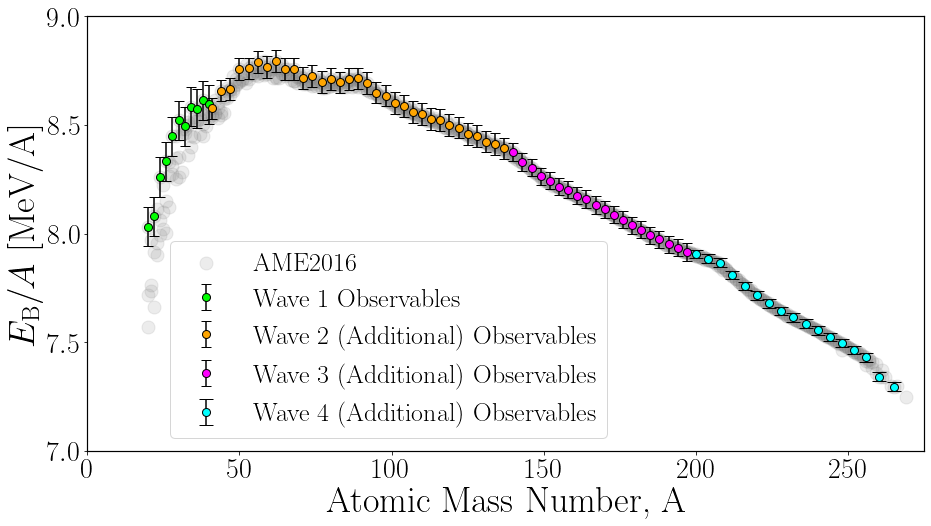

In [19]:
fig, ax = plt.subplots(figsize=(15,8))

ax.scatter(A, Energies, color='gray', s=170, zorder=1, alpha=0.15, label='AME2016')

ax.errorbar(A_single[nuclei_groups1[0][0]:nuclei_groups1[0][1]:2], Energies_single[nuclei_groups1[0][0]:nuclei_groups1[0][1]:2], \
            yerr = sigma_model_groups[0], marker='o', ecolor='black', \
            capsize=5, ls='none', mfc='lime', mec='black', ms=8, zorder=2, \
            label='Wave 1 Observables')

ax.errorbar(A_single[nuclei_groups1[1][0]:nuclei_groups1[1][1]:3], Energies_single[nuclei_groups1[1][0]:nuclei_groups1[1][1]:3], \
            yerr = sigma_model_groups[1], marker='o', ecolor='black', \
            capsize=5, ls='none', mfc='orange',  mew=1, mec='black', ms=8, zorder=2, \
            label='Wave 2 (Additional) Observables')

ax.errorbar(A_single[nuclei_groups1[2][0]:nuclei_groups1[2][1]:3], Energies_single[nuclei_groups1[2][0]:nuclei_groups1[2][1]:3], \
            yerr = sigma_model_groups[2], marker='o', ecolor='black', \
            capsize=5, ls='none', mfc='magenta', mec='black', ms=8, zorder=2, \
            label='Wave 3 (Additional) Observables')

ax.errorbar(A_single[nuclei_groups1[3][0]:nuclei_groups1[3][1]:4], Energies_single[nuclei_groups1[3][0]:nuclei_groups1[3][1]:4], \
                                  yerr = sigma_model_groups[3], marker='o', ecolor='black', \
            capsize=7, ls='none', mfc='cyan', mec='black', ms=8, zorder=2, \
            label='Wave 4 (Additional) Observables')


print(A[nuclei_groups[3][0]:nuclei_groups[3][1]:4])
#markers.set_alpha(0.5)
ax.set_xlabel('Atomic Mass Number, A')
ax.set_ylabel(r'$E_{\mathrm{B}}/A$ [MeV/A]')
ax.set_ylim([7,9])
ax.set_xlim([0,275])
ax.legend(loc=8, bbox_to_anchor=(0.36,0))
plt.savefig('figures/observables.pdf', bbox_inches='tight', facecolor='white', transparent=False)

#print(len(A_single[nuclei_groups1[1][0]:nuclei_groups1[1][1]:3]))

0.010041753860663354
0.024924963752224916


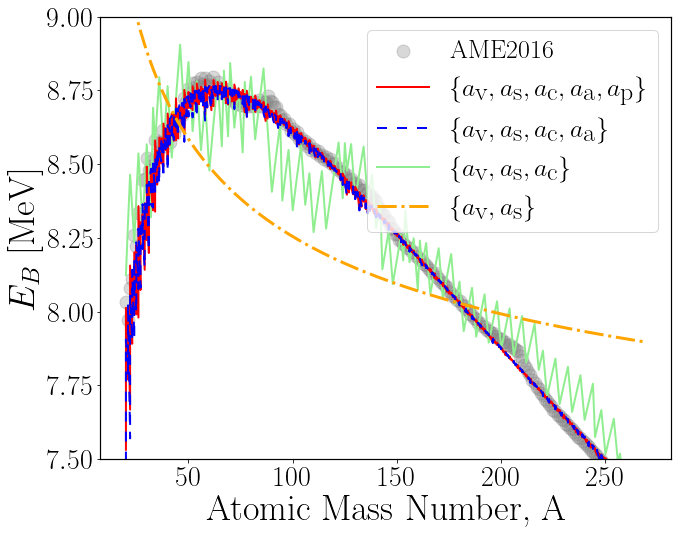

In [20]:
# check for most important active variables


fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(A_single, Energies_single, color='gray', s=170, zorder=1, alpha=0.3, label='AME2016')
ax.plot(A, preds_5d, color='red', linewidth=2, \
             label=r'$\{a_{\textrm{v}},a_{\textrm{s}},a_{\textrm{c}},a_{\textrm{a}},a_{\textrm{p}}\}$')
ax.plot(A, preds_4d, color='blue', linestyle=(0, (5, 5)), linewidth=2, \
            label=r'$\{a_{\textrm{v}},a_{\textrm{s}},a_{\textrm{c}},a_{\textrm{a}}\}$')
ax.plot(A_single, preds_3d, color='lightgreen', linewidth=2, zorder=1, \
            label=r'$\{a_{\textrm{v}},a_{\textrm{s}},a_{\textrm{c}}\}$')
ax.plot(A_single, preds_2d, color='orange', linewidth=3, ls='-.', \
            label=r'$\{a_{\textrm{v}},a_{\textrm{s}}\}$')
#axes[0].scatter(A0, Energies0, color='grey', s=120, alpha=0.3, label='AME2016')


inactive_sigma = np.sqrt(np.sum(np.square(preds_5d[50:] - preds_4d[50:])) / len(preds_5d[50:]))
print(inactive_sigma)
inactive_sigma = 0.02



#plt.savefig('figures/inactive_modelsigma.png', bbox_inches='tight', facecolor='white', transparent=False)

evenA = np.where(A % 2 == 0)[0]
oddA = np.where(A % 2 != 0)[0]

print(np.sqrt(np.mean(np.square(Energies[evenA[:-1]]-Energies[oddA[:-1]]))))


#axes[0].set_ylim([7.2,9])
ax.set_xlabel('Atomic Mass Number, A')
ax.set_ylabel(r'$E_{B}$ [MeV]')
ax.legend(loc='upper right')
ax.set_ylim([7.5,9])

plt.tight_layout()
plt.savefig('figures/active_parameters_a.pdf', bbox_inches='tight', facecolor='white', transparent=False)

0.010041753860663354
0.024924963752224916


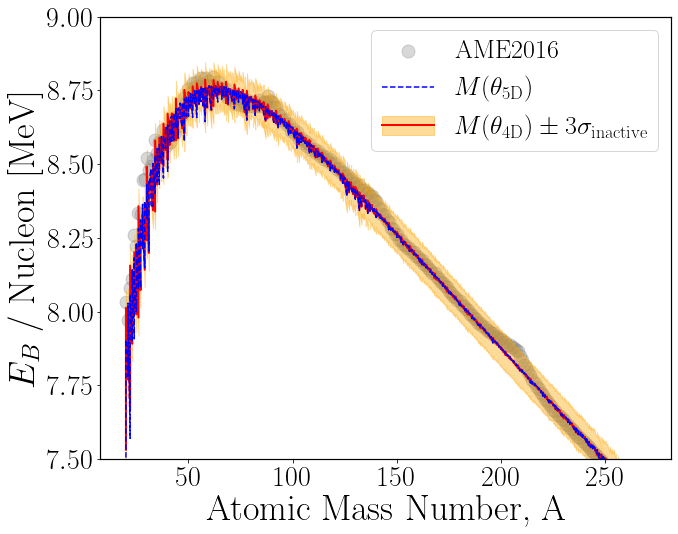

In [21]:
fig, ax = plt.subplots(figsize=(10,8))

dataplot = ax.scatter(A_single, Energies_single, color='gray', s=170, zorder=1, alpha=0.3, label='AME2016')

plot5d, = ax.plot(A, preds_5d, color='red', linewidth=2, zorder=3, label='SEMF Prediction 5D')

plot6d, = ax.plot(A, preds_4d, color='blue', ls='--',zorder=4, label='SEMF Prediction 6D')

inactive_sigma = np.sqrt(np.sum(np.square(preds_5d[50:] - preds_4d[50:])) / len(preds_5d[50:]))
print(inactive_sigma)
inactive_sigma = 0.02

plotsigma5d = ax.fill_between(A, preds_5d-3*inactive_sigma, preds_5d+3*inactive_sigma, zorder=2, color='orange', alpha=0.4)

ax.legend([dataplot, plot6d, (plotsigma5d, plot5d)], ['AME2016', r'${M}(\theta_{5\mathrm{D}})$', r'${M}(\theta_{4\mathrm{D}}) \pm 3\sigma_{\mathrm{inactive}}$'], loc='best')

#plt.savefig('figures/inactive_modelsigma.png', bbox_inches='tight', facecolor='white', transparent=False)

evenA = np.where(A % 2 == 0)[0]
oddA = np.where(A % 2 != 0)[0]

print(np.sqrt(np.mean(np.square(Energies[evenA[:-1]]-Energies[oddA[:-1]]))))



ax.set_xlabel('Atomic Mass Number, A')
ax.set_ylabel(r'$E_{B}$ / Nucleon [MeV]')
ax.set_ylim([7.5,9])

plt.tight_layout()
plt.savefig('figures/active_parameters_b.pdf', bbox_inches='tight', facecolor='white', transparent=False)

0.010041753860663354


 /tmp/ipykernel_79023/172085952.py:16: UserWarning:Legend does not support [<matplotlib.lines.Line2D object at 0x7f1084eceb60>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


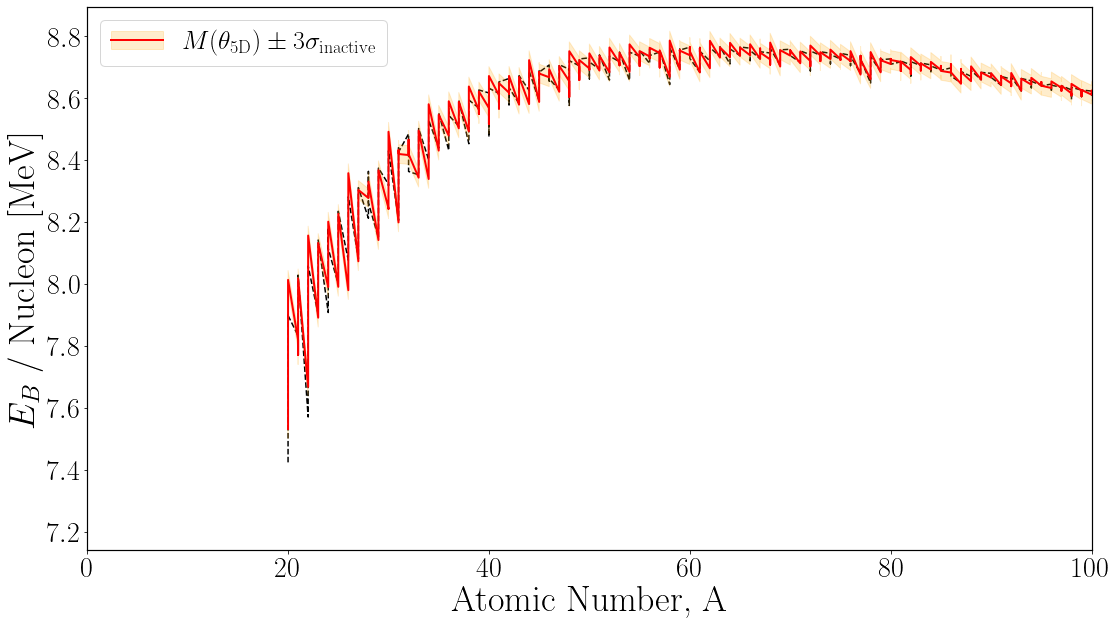

In [22]:
fig, ax1 = plt.subplots(figsize=(18,10))

plot5d, = ax1.plot(A, preds_5d, color='red', linewidth=2, zorder=3, label='SEMF Prediction 5D')
#plot6d = ax1.scatter(A, preds_4d, ec='black', fc='grey', s=30, zorder=4, label='SEMF Prediction 6D')
plot6d = ax1.plot(A, preds_4d, color='black', ls='--', label='SEMF Prediction 6D')


ax1.set_xlabel('Atomic Number, A')
ax1.set_ylabel(r'$E_{B}$ / Nucleon [MeV]')


inactive_sigma = np.sqrt(np.sum(np.square(preds_5d[50:] - preds_4d[50:])) / len(preds_5d[50:]))

plotsigma5d = ax1.fill_between(A, preds_5d-3*inactive_sigma, preds_5d+3*inactive_sigma, zorder=2, color='orange', alpha=0.2)

ax1.legend([plot6d, (plotsigma5d, plot5d)], [r'${M}(\theta_{6\mathrm{D}})$', r'${M}(\theta_{5\mathrm{D}}) \pm 3\sigma_{\mathrm{inactive}}$'], loc='best')

ax1.set_xlim([0,100])
#plt.savefig('figures/inactive_modelsigma.png', bbox_inches='tight', facecolor='white', transparent=False)

evenA = np.where(A0 % 2 == 0)[0]
oddA = np.where(A0 % 2 != 0)[0]

print(inactive_sigma)
#np.sqrt(np.var(np.abs(Energies0[evenA[:-3]]-Energies0[oddA[:-1]])))


# Analytical Isoprobability Surfaces

In [23]:
# compute variance for variables to be used in each wave
sigma_model_groups = [0.09, 0.05, 0.04, 0.02]
variances = []

Ngroups = 4       # corresponding to observables in each wave

for i in range(Ngroups):
    maxA = nuclei_groups[i][1]
    variances.append(np.mean(Energies_unc[:maxA])**2 + sigma_model_groups[i]**2)


In [24]:
def A_matrix(X_d, variance):
    for i in range(X_d.shape[0]):
        X_d[i] = X_d[i] / np.sqrt(variance)
    return X_d

In [25]:
def H_matrix(A):
    return np.linalg.inv(A.T.dot(A))

def covariance(X_d, variance):
    return variance*np.linalg.inv(X_d.T.dot(X_d))

In [26]:
A_matrices = []
b = []
cov_matrices = []

# iterate through groups of A, ap inactive
for i in range(Ngroups):
    maxA = nuclei_groups[i][1]
    XD = design_matrix_Agroup(ndim, A_single, Z_single, N_single, maxA)
    A_matrices.append(A_matrix(XD, variances[i]))
    cov_matrices.append(covariance(XD, variances[i]))
    b.append(Energies_single[:maxA] / np.sqrt(variances[i]))
    
# final analytical solution, including ap
maxA = nuclei_groups[-1][1]
XD = design_matrix(ndim)
A_matrices.append(A_matrix(XD, variances[-1]))
cov_matrices.append(covariance(XD, variances[-1]))
b.append(Energies / np.sqrt(variances[-1]))


In [27]:
def solve_theta(A, b):
    theta_best = ((np.linalg.inv(A.T.dot(A))).dot(A.T)).dot(b)
    return theta_best.flatten()

In [28]:
thetas = []
for i in range(Ngroups+1):
    thetas.append(solve_theta(A_matrices[i], b[i]))

In [29]:
H_matrices = []
covariance_matrices = []

for i in range(Ngroups+1):
    H_matrices.append(H_matrix(A_matrices[i]))

In [70]:
ellipsoid_wave5 = np.loadtxt('data/w5_ellipsoid_nonimp.txt')
HM_cov = np.cov(ellipsoid_wave5[:,:-1].T)
print(HM_cov.shape)

(5, 5)


In [71]:
# hessian principle component analysis 
Hess = np.linalg.inv(HM_cov)

Hess_tilde = np.zeros_like(Hess)
for i in range(5):
    for j in range(5):
        Hess_tilde[i,j] = Hess[i,j] / (np.sqrt(Hess[i,i])*np.sqrt(Hess[j,j]))

eigvec, eigval, eigvec = np.linalg.svd(Hess_tilde)
print(eigval)

[3.47845539e+00 1.00039052e+00 4.25425423e-01 9.43890573e-02
 1.33961126e-03]


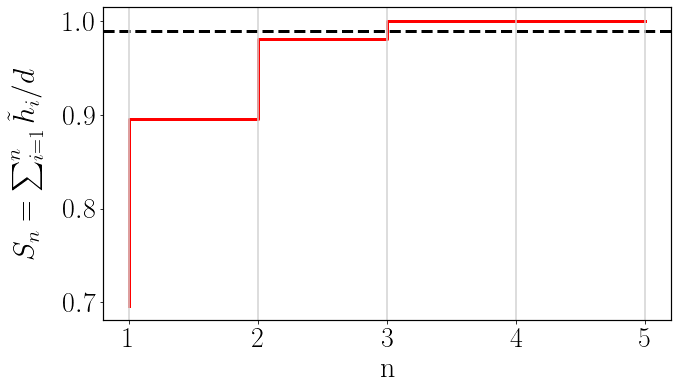

In [73]:
fig, ax = plt.subplots(figsize=(10,6))

#evaluate the cumulative
cumulative = np.cumsum(eigval)
# plot the cumulative function
ax.step(np.linspace(1,5,5), cumulative/5, color='red', lw=3)
ax.axhline(0.99, color='black', ls='--', lw=3)
ax.axvline(1, color='lightgrey')
ax.axvline(2, color='lightgrey')
ax.axvline(3, color='lightgrey')
ax.axvline(4, color='lightgrey')
ax.axvline(5, color='lightgrey')

#ax.set_ylim([0.9,1.01])
ax.set_xticks([1,2,3,4,5])
ax.set_xlabel('n')
ax.set_ylabel(r'$S_{n} = \sum^{n}_{i=1}\tilde{h}_{i} / d$')
ax.yaxis.labelpad = 20
fig.tight_layout()

plt.savefig('figures/cumulative_S.pdf', bbox_inches='tight', facecolor='white', transparent=False)

In [32]:
def get_cov_ellipse(cov, centre, nstd, ax, color):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * np.sqrt(5.991) * np.sqrt(np.abs(eigvals))
    
    t = np.linspace(0, 2*np.pi, 100)
    Ell = np.array([0.5*width*np.cos(t) , 0.5*height*np.sin(t)]) 
    R_rot = np.array([[np.cos(theta) , -np.sin(theta)],[np.sin(theta), np.cos(theta)]])  
    Ell_rot = np.zeros((2,Ell.shape[1]))
    for i in range(Ell.shape[1]):
        Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
    
    ax.plot( centre[0]+Ell_rot[0,:] , centre[1]+Ell_rot[1,:], color=color,linewidth=3)
    #ax.plot(Ell_rot[:,0], Ell_rot[:,1])

In [33]:
dec_list = [1,2,2,3,3,2]

In [38]:
def plot_ellipses(fig, parameter_bounds, H, theta_best, theta_vals, color, ndim):
    theta_names = [r'$a_{\textrm{v}}$ [MeV]', r'$a_{\textrm{s}}$ [MeV]', r'$a_{\textrm{c}}$ [MeV]', r'$a_{\textrm{a}}$ [MeV]', r'$a_{\textrm{p}}$ [MeV]']
    theta_names2 = [r'$a_{\textrm{v}}$', r'$a_{\textrm{s}}$', r'$a_{\textrm{c}}$', r'$a_{\textrm{a}}$', r'$a_{\textrm{p}}$']
    for i in range(H.shape[0]):
        for j in range(H.shape[0]):
            ax = fig.axes[i + ndim*j]
            if i != 0:
                ax.axes.yaxis.set_visible(False)
                
            if i == j:
                ax.axes.yaxis.set_visible(False)
                #ax.axis('off')
                theta_val = np.linspace(theta_best[i] - 3*np.sqrt(H[i,i]), theta_best[i] + 3*np.sqrt(H[i,i]), 100)
                ax.plot(theta_val, stats.norm.pdf(theta_val, theta_best[i], np.sqrt(H[i,i])), color='black', linewidth=3)
                ax.axvline(theta_best[i], color='red', linestyle='--',linewidth=2)
                
                xmin = theta_best[i] - 3*np.sqrt(H[i,i])
                xmax = theta_best[i] + 3*np.sqrt(H[i,i])
                ax.set_xlim([xmin, xmax])
                ax.set_xticks([theta_best[i] - 2*np.sqrt(H[i,i]), theta_best[i], theta_best[i] + 2*np.sqrt(H[i,i])])
                
                ax.set_xticklabels(np.around([theta_best[i] - 2*np.sqrt(H[i,i]), theta_best[i], theta_best[i] + 2*np.sqrt(H[i,i])],2), rotation = 45, ha="right")
            
                #ax.set_xticks([0.99*theta_best[i], theta_best[i], 1.01*theta_best[i]])
                #ax.axvline(theta_best[i]+2*np.sqrt(H[i,i]), linestyle='--', color='black')
                #ax.axvline(theta_best[i]-2*np.sqrt(H[i,i]), linestyle='--', color='black')
                #ax.set_xticks(np.linspace(parameter_bounds[i,0]*1.01, parameter_bounds[i,1], 5))
                #ax.set_xticklabels(np.around(np.linspace(parameter_bounds[i,0]*1.01, parameter_bounds[i,1], 5),dec_list[i]), rotation = 45, ha="right")
                
                if i == 3:
                    ax.set_title(str(theta_names2[i]) + '=' + str(round(theta_best[i], 3)) + r'$\pm$' + \
                                   str(round(np.sqrt(H[i,i]),4)))
                else:
                    ax.set_title(str(theta_names2[i]) + '=' + str(round(theta_best[i], 3)) + r'$\pm$' + \
                                       str(round(np.sqrt(H[i,i]),3)))
                
            elif i < j:
                cov_matrix = np.array([[H[i,i], H[i,j]],[H[j,i], H[j,j]]])
                ax.axvline(theta_best[i], linestyle='--', color='red')
                ax.axhline(theta_best[j], linestyle='--', color='red')
                get_cov_ellipse(cov_matrix, [theta_best[i], theta_best[j]], 3, ax, color)
                #if j == ndim-1:
                ax.set_ylabel(theta_names[j])
                ax.set_xlabel(theta_names[i])
                    
                #ax.set_xticks(np.linspace(initial_parameter_bounds[i,0], initial_parameter_bounds[i,1], 5))
                #ax.set_xticklabels(np.around(np.linspace(initial_parameter_bounds[i,0]*1.01, initial_parameter_bounds[i,1], 5),dec_list[i]), rotation = 45, ha="right")
                #ax.set_yticks(np.linspace(initial_parameter_bounds[j,0], initial_parameter_bounds[j,1], 5))
                ##ax.set_yticklabels(np.around(np.linspace(initial_parameter_bounds[j,0], initial_parameter_bounds[j,1], 5),dec_list[j]), rotation = 45, ha="right")
                
                
                #nbins = len(ax.get_xticklabels())
                #ax.yaxis.set_major_locator(MaxNLocator(nbins=4,prune='upper'))
                #ax.xaxis.set_major_locator(MaxNLocator(nbins=4,prune='upper'))
                
                #theta_val = np.linspace(0.9*theta_best[i], 1.1*theta_best[i], 100)
                xmin = theta_best[i] - 3*np.sqrt(H[i,i])
                xmax = theta_best[i] + 3*np.sqrt(H[i,i])
                ymin = theta_best[j] - 3*np.sqrt(H[j,j])
                ymax = theta_best[j] + 3*np.sqrt(H[j,j])
                ax.set_xlim([xmin, xmax])
                ax.set_ylim([ymin, ymax])
                
                ax.set_xticks([theta_best[i] - 2*np.sqrt(H[i,i]), theta_best[i], theta_best[i] + 2*np.sqrt(H[i,i])])
                ax.set_yticks([theta_best[j] - 2*np.sqrt(H[j,j]), theta_best[j], theta_best[j] + 2*np.sqrt(H[j,j])])
                
                ax.set_xticklabels(np.around([theta_best[i] - 2*np.sqrt(H[i,i]), theta_best[i], theta_best[i] + 2*np.sqrt(H[i,i])],2), rotation = 45, ha="right")
                ax.set_yticklabels(np.around([theta_best[j] - 2*np.sqrt(H[j,j]), theta_best[j], theta_best[j] + 2*np.sqrt(H[j,j])],2), rotation = 45, ha="right")
                #ax.yaxis.set_major_locator(MaxNLocator(nbins=3,prune='upper'))
                #ax.xaxis.set_major_locator(MaxNLocator(nbins=3,prune='upper'))
                
            else:
                ax.axis('off')
                
        #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=None)
 
        #plt.tight_layout(pad=0.0)


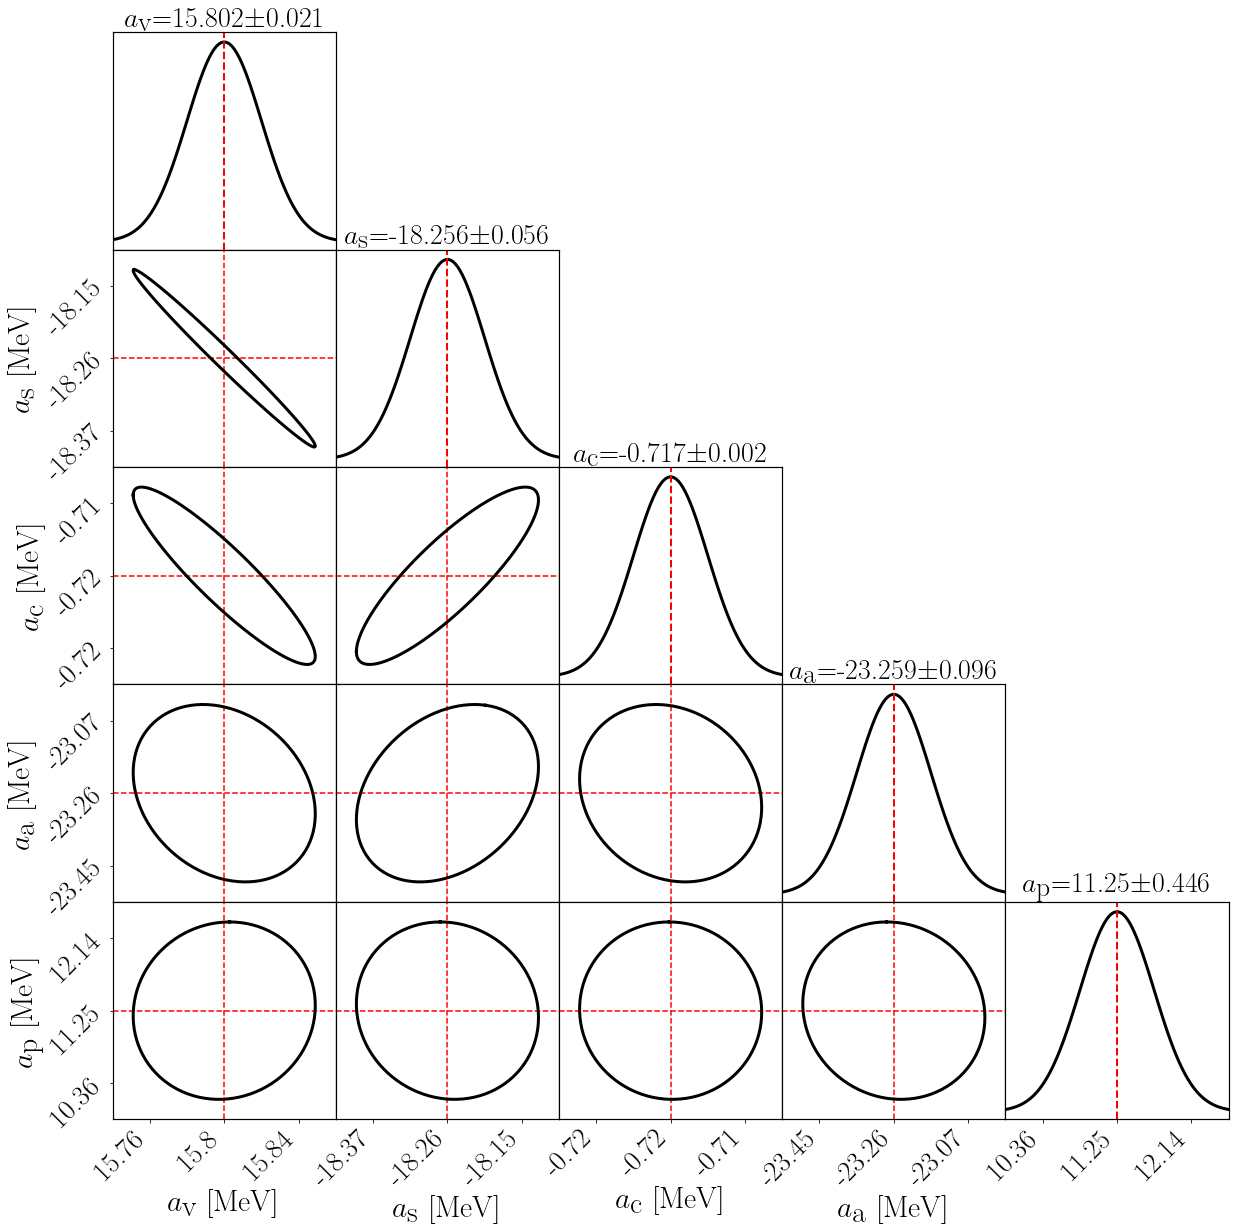

In [47]:
color_list = ['black', 'plum', 'mediumaquamarine', 'red']
fig, axes = plt.subplots(ndim,ndim,figsize=(20,20), sharex='col')


#plot_ellipses(fig, parameter_bounds, H_matrices[0], thetas[0], theta_vals, color_list[1], ndim)
#plot_ellipses(fig, parameter_bounds, H_matrices[1], thetas[1], theta_vals, color_list[2], ndim)
#plot_ellipses(fig, parameter_bounds, H_matrices[2], thetas[2], theta_vals, color_list[3], ndim)
plot_ellipses(fig, parameter_bounds, H_matrices[-1], thetas[-1], theta_vals, color_list[0], ndim)
#fig.suptitle(r'Analytical Likelihood (95% Isoprobability Surface)')

fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig('figures/analytical_corner.pdf', bbox_inches='tight', facecolor='white', transparent=False)

In [48]:
for j in range(Ngroups):

    file2 = open("data/5D_analytic_mean_group{}.txt".format(j+1), "w")

    np.savetxt(file2, thetas[j])

    file2.close()

    file1 = open("data/5D_analytic_cov_group{}.txt".format(j+1), "w")

    for i in range(H_matrices[j].shape[0]):
        np.savetxt(file1, H_matrices[j][i])

    file1.close()
    
file2 = open("data/5D_analytic_mean_final.txt", "w")

np.savetxt(file2, thetas[-1])

file2.close()

file1 = open("data/5D_analytic_cov_final.txt", "w")

for i in range(H_matrices[-1].shape[0]):
    np.savetxt(file1, H_matrices[-1][i])

file1.close()


# Nearest Neighbour Calculations

In [49]:
nn_samples = [10**3, 10**4, 10**5, 10**6]

In [50]:
# import wave 1 nonimplausible samples
nonimplausible_wave1 = np.loadtxt('data/w1_gaussian_nonimp.txt')

In [51]:
# compute mean and covariance of wave 1 nonimp volume
# both HC and GA will have this same region after wave 1, and generate well spaced samples accordingly

# compute mean and covariance for gaussian sampling
wave1_mean = np.mean(nonimplausible_wave1[:,:-1], axis=0)
wave1_cov = np.cov(nonimplausible_wave1[:,:-1].T)

# compute bounds for hypercube sampling
wave1_bounds = utils.locate_boundaries(nonimplausible_wave1[:,:-1], ndim-1)

In [52]:
importlib.reload(sample)

# sample from wave 1 gaussian and find avg nn distance

nn_dist_gauss_2sigma = np.zeros((2,5))
nn_dist_gauss_1sigma = np.zeros((2,5))

avg_distance_per_dim_gaussian_2sigma = np.zeros((len(nn_samples),ndim-1))
avg_distance_per_dim_gaussian_1sigma = np.zeros((len(nn_samples),ndim-1))
avg_distance_per_dim_hypercube = np.zeros((len(nn_samples),ndim-1))
avg_distance_per_dim_ellipsoid = np.zeros((len(nn_samples),ndim-1))
avg_distance_per_dim_hypercube_rot = np.zeros((len(nn_samples),ndim-1))

for i in range(len(nn_samples)):
    
    # generate samples corresponding to wave 1 gaussian
    discard, testsamples = sample.gaussian_sample(4, nn_samples[i], 2, nonimplausible_wave1[:,:-1])
    
    # find all samples with 1 and 2 sigma
    mdist = spatial.distance.cdist(testsamples, wave1_mean.reshape(1,-1), metric='mahalanobis')[:,0]
    sigma2_samples = testsamples[mdist < 2]
    sigma1_samples = testsamples[mdist < 1]
    
    # rescale points
    scaler2sigma = StandardScaler()
    scaler1sigma = StandardScaler()
    scaler2sigma.fit(sigma2_samples)
    scaler1sigma.fit(sigma1_samples)
    sigma2_samples_rescaled = scaler2sigma.transform(sigma2_samples)
    sigma1_samples_rescaled = scaler1sigma.transform(sigma1_samples)
    
    # calculate nearest neighbours
    nbrs_2sigma = NearestNeighbors(n_neighbors=2, algorithm='auto', metric='euclidean').fit(sigma2_samples_rescaled)
    nbrs_1sigma = NearestNeighbors(n_neighbors=2, algorithm='auto', metric='euclidean').fit(sigma1_samples_rescaled)
    distances_2sigma, indices_2sigma = nbrs_2sigma.kneighbors(sigma2_samples_rescaled)
    distances_1sigma, indices_1sigma = nbrs_1sigma.kneighbors(sigma1_samples_rescaled)
    
    # find average distance between NN in each dimension
    avgdist_2sigma = np.sum(np.abs(sigma2_samples[indices_2sigma[:,0]] - sigma2_samples[indices_2sigma[:,1]]), axis=0)
    avgdist_2sigma /= len(sigma2_samples)
    avg_distance_per_dim_gaussian_2sigma[i] = avgdist_2sigma
    
    avgdist_1sigma = np.sum(np.abs(sigma1_samples[indices_1sigma[:,0]] - sigma1_samples[indices_1sigma[:,1]]), axis=0)
    avgdist_1sigma /= len(sigma1_samples)
    avg_distance_per_dim_gaussian_1sigma[i] = avgdist_1sigma
    
    
    # generate samples corresponding to wave 1 ellipsoid
    discard, testsamples_el = sample.uniform_ellipsoid_sample(4, nn_samples[i], 2, nonimplausible_wave1[:,:-1])
    
    # rescale points
    scaler_el = StandardScaler()
    scaler_el.fit(testsamples_el)
    testsamples_el_rescaled = scaler_el.transform(testsamples_el)
    
    # calculate nearest neighbours
    nbrs_el = NearestNeighbors(n_neighbors=2, algorithm='auto', metric='euclidean').fit(testsamples_el_rescaled)
    distances_el, indices_el = nbrs_el.kneighbors(testsamples_el_rescaled)
    
    # find average distance between NN in each dimension
    avgdist_el = np.sum(np.abs(testsamples_el[indices_el[:,0]] - testsamples_el[indices_el[:,1]]), axis=0)
    avgdist_el /= len(testsamples_el)
    avg_distance_per_dim_ellipsoid[i] = avgdist_el
    
    
    
    

    # generate hypercube samples with wave 1 boundaries
    discard, testsamples_hc = sample.hypercube_sample(ndim-1, nn_samples[i], 2, nonimplausible_wave1[:,:-1])
    
    # rescale points
    scaler = StandardScaler()
    scaler.fit(testsamples_hc)
    testsamples_hc_rescaled = scaler.transform(testsamples_hc)
    
    # calculate nearest neighbours
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto', metric='euclidean').fit(testsamples_hc_rescaled)
    distances_hc, indices_hc = nbrs.kneighbors(testsamples_hc_rescaled)
    
    # find average distance between NN in each dimension
    avgdist_hc = np.sum(np.abs(testsamples_hc[indices_hc[:,0]] - testsamples_hc[indices_hc[:,1]]), axis=0)
    avgdist_hc /= len(testsamples_hc)
    avg_distance_per_dim_hypercube[i] = avgdist_hc
    
    
    
    # generate rotated hypercube samples with wave 1 boundaries and covariance
    discard, testsamples_hc_rot = sample.rotated_hypercube_sample(ndim-1, nn_samples[i], 2, nonimplausible_wave1[:,:-1], parameter_bounds=None, inactive=False)
    
    # rescale points
    scaler_rot = StandardScaler()
    scaler_rot.fit(testsamples_hc_rot)
    testsamples_hc_rot_rescaled = scaler.transform(testsamples_hc_rot)
    
    # calculate nearest neighbours
    nbrs_rot = NearestNeighbors(n_neighbors=2, algorithm='auto', metric='euclidean').fit(testsamples_hc_rot_rescaled)
    distances_hc_rot, indices_hc_rot = nbrs_rot.kneighbors(testsamples_hc_rot_rescaled)
    
    # find average distance between NN in each dimension
    avgdist_hc_rot = np.sum(np.abs(testsamples_hc_rot[indices_hc_rot[:,0]] - testsamples_hc_rot[indices_hc_rot[:,1]]), axis=0)
    avgdist_hc_rot /= len(testsamples_hc_rot)
    avg_distance_per_dim_hypercube_rot[i] = avgdist_hc_rot
    

In [53]:
# import analytical wave 4
analytic_mean_wave2 = np.loadtxt("data/5D_analytic_mean_final.txt").reshape(ndim,)
analytic_cov_wave2 = np.loadtxt("data/5D_analytic_cov_final.txt").reshape(ndim,ndim)

analytical_range = []
for i in range(ndim-1):
    analytical_range.append(2*3*np.sqrt(analytic_cov_wave2[i,i]))


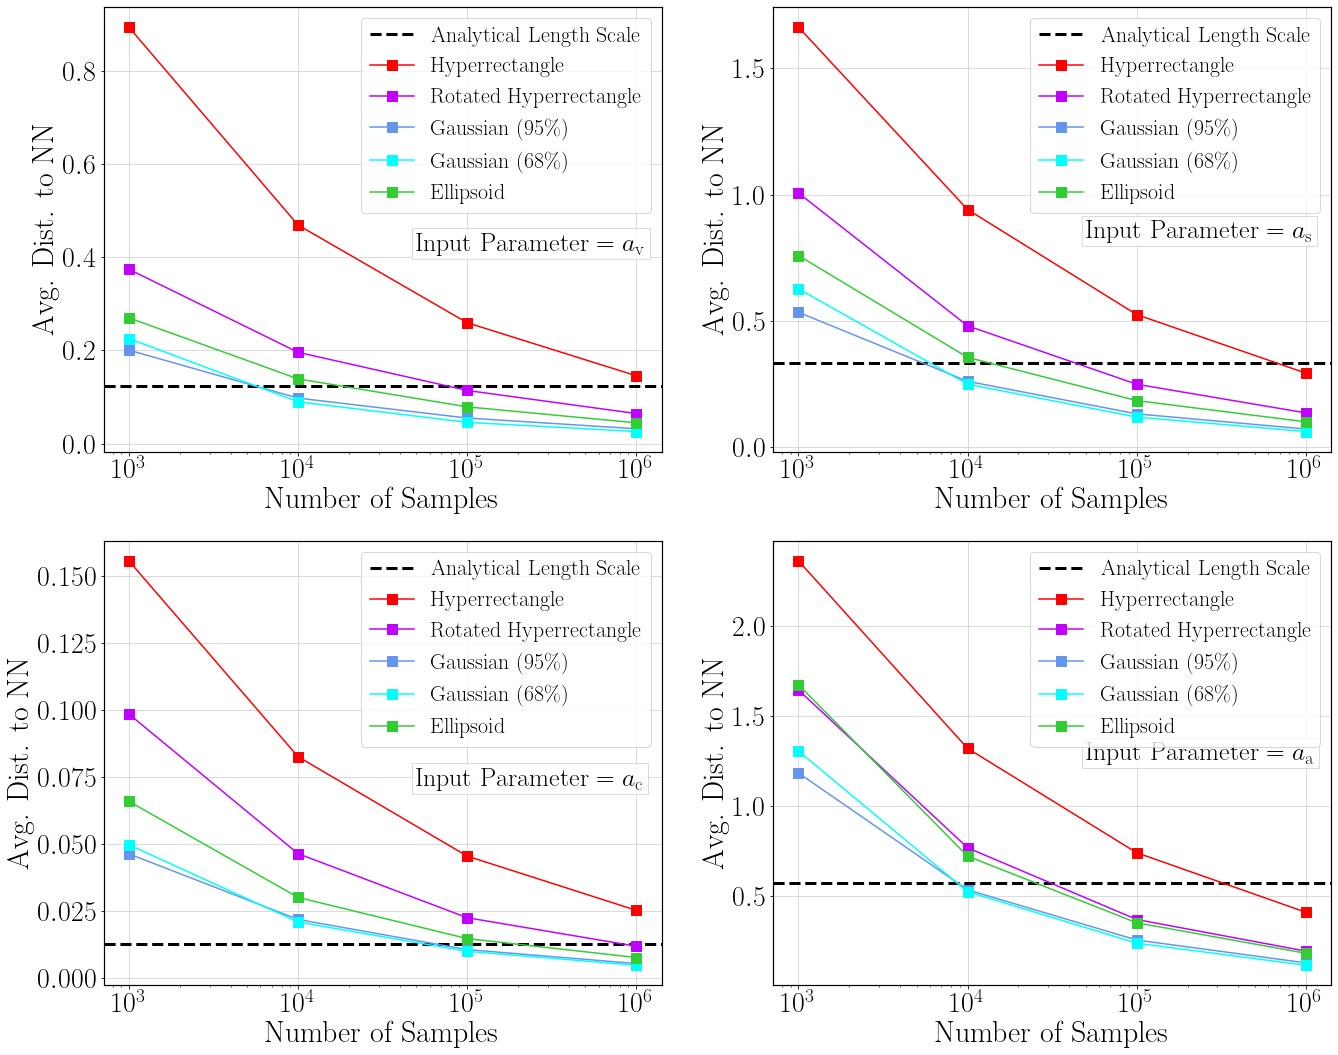

In [54]:
# ********* note: this is starting range dependant! ***********
# potentially also dependent on the inactive parameter sigma that I choose
# increase this sigma for a larger first wave nonimplausible volume
# and this should lead to a larger sample space

fig, axes = plt.subplots(2,2, figsize=(22,18))
for i in range(ndim-1):
    if i < 2:
        ax = axes[0,i]
    else:
        ax = axes[1,i-(ndim-1)]
    ax.axhline(analytical_range[i], color='black', ls='--', linewidth=3, label='Analytical Length Scale')
    ax.plot(nn_samples, avg_distance_per_dim_hypercube[:,i], color='red', linestyle='-', marker="s", ms=10, label='Hyperrectangle')
    ax.plot(nn_samples, avg_distance_per_dim_hypercube_rot[:,i], color='#c100ff', linestyle='-', marker="s", ms=10, label='Rotated Hyperrectangle')
    ax.plot(nn_samples, avg_distance_per_dim_gaussian_2sigma[:,i], color='cornflowerblue', linestyle='-', marker="s", ms=10, label='Gaussian (95\%)')
    ax.plot(nn_samples, avg_distance_per_dim_gaussian_1sigma[:,i], color='cyan', linestyle='-', marker="s", ms=10, label='Gaussian (68\%)')
    ax.plot(nn_samples, avg_distance_per_dim_ellipsoid[:,i], color='limegreen', linestyle='-', marker="s", ms=10, label='Ellipsoid')
    
    ax.set_xlabel('Number of Samples')
    ax.set_ylabel('Avg. Dist. to NN')
    ax.grid(color='lightgrey')
    ax.set_xscale('log')
    ax.legend(loc='upper right', fontsize=22)
    
axes[0,0].text(50000, 0.415, 'Input Parameter = $a_{\mathrm{v}}$', fontsize=26, 
         bbox = dict(facecolor = 'white', edgecolor='lightgrey', alpha = 0.8));
axes[0,1].text(50000, 0.83, 'Input Parameter = $a_{\mathrm{s}}$', fontsize=26, 
         bbox = dict(facecolor = 'white', edgecolor='lightgrey', alpha = 0.8)); 
axes[1,0].text(50000, 0.072, 'Input Parameter = $a_{\mathrm{c}}$', fontsize=26, 
         bbox = dict(facecolor = 'white', edgecolor='lightgrey', alpha = 0.8));
axes[1,1].text(50000, 1.26, 'Input Parameter = $a_{\mathrm{a}}$', fontsize=26, 
         bbox = dict(facecolor = 'white', edgecolor='lightgrey', alpha = 0.8));

plt.savefig('figures/nearestneighbour_per_dim.pdf', bbox_inches='tight', facecolor='white', transparent=False)

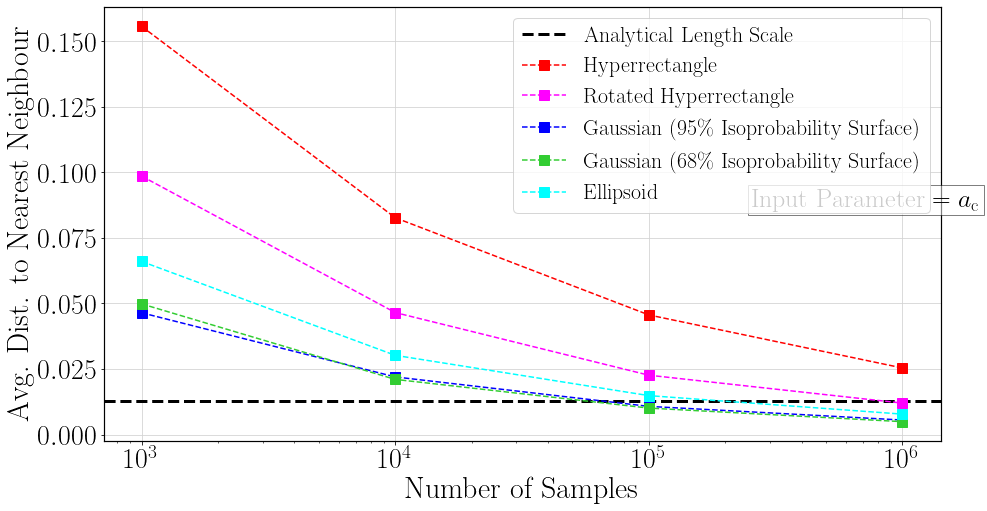

In [55]:
fig, ax = plt.subplots(figsize=(15,8))

ax.axhline(analytical_range[2], color='black', ls='--', linewidth=3, label='Analytical Length Scale')
ax.plot(nn_samples, avg_distance_per_dim_hypercube[:,2], color='red', linestyle='--', marker="s", ms=10, label='Hyperrectangle')
ax.plot(nn_samples, avg_distance_per_dim_hypercube_rot[:,2], color='magenta', linestyle='--', marker="s", ms=10, label='Rotated Hyperrectangle')
ax.plot(nn_samples, avg_distance_per_dim_gaussian_2sigma[:,2], color='blue', linestyle='--', marker="s", ms=10, label='Gaussian (95\% Isoprobability Surface)')
ax.plot(nn_samples, avg_distance_per_dim_gaussian_1sigma[:,2], color='limegreen', linestyle='--', marker="s", ms=10, label='Gaussian (68\% Isoprobability Surface)')
ax.plot(nn_samples, avg_distance_per_dim_ellipsoid[:,2], color='cyan', linestyle='--', marker="s", ms=10, label='Ellipsoid')
    
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Avg. Dist. to Nearest Neighbour')
ax.grid(color='lightgrey')
ax.set_xscale('log')
ax.legend(loc='upper right')
    
ax.text(255000, 0.087, 'Input Parameter = $a_{\mathrm{c}}$', fontsize=26, 
         bbox = dict(facecolor = 'white', alpha = 0.5));

plt.savefig('figures/nn_ac.pdf', bbox_inches='tight', facecolor='white', transparent=False)

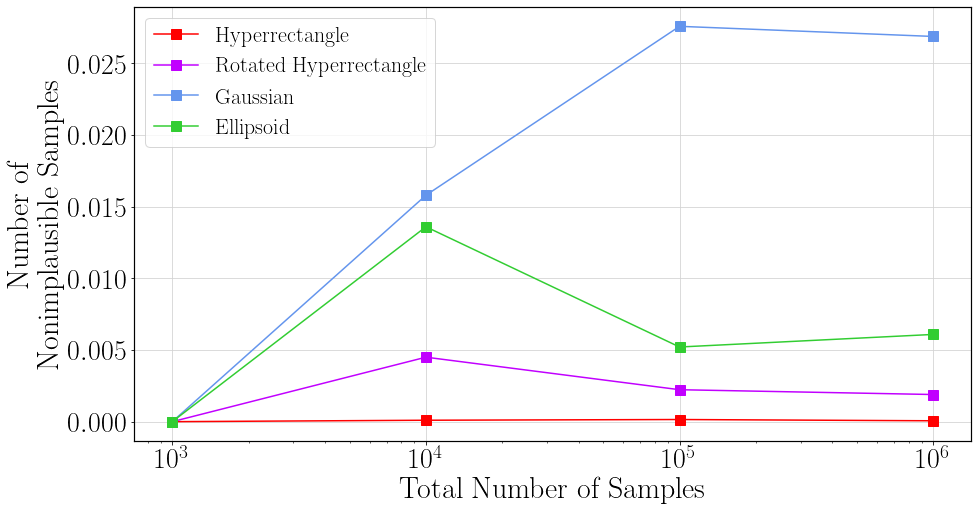

In [63]:
# plot showing fraction of samples that are nonimplausible

gaussian_frac_samples = np.array([0,158,2759,26883])/nn_samples
hypercube_frac_samples = np.array([0,1,15,62])/nn_samples
hypercube_rot_frac_samples = np.array([0,45,223,1894])/nn_samples
ellipsoid_frac_samples = np.array([0,136,521,6088])/nn_samples

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(nn_samples, hypercube_frac_samples, color='red', linestyle='-', marker="s", ms=10, label='Hyperrectangle')
ax.plot(nn_samples, hypercube_rot_frac_samples, color='#c100ff', linestyle='-', marker="s", ms=10, label='Rotated Hyperrectangle')
ax.plot(nn_samples, gaussian_frac_samples, color='cornflowerblue', linestyle='-', marker="s", ms=10, label='Gaussian')
ax.plot(nn_samples, ellipsoid_frac_samples, color='limegreen', linestyle='-', marker="s", ms=10, label='Ellipsoid')

ax.set_xlabel('Total Number of Samples')
ax.set_ylabel('Number of \nNonimplausible Samples')
ax.grid(color='lightgrey')
#ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc='upper left')
plt.savefig('figures/number_nonimp.pdf', bbox_inches='tight', facecolor='white', transparent=False)